In [3]:
#All imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,f1_score
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
import pickle

In [4]:


# Load the category tree data
df_category_tree = pd.read_csv('./category_tree.csv')

# Load the events data
df_events = pd.read_csv('./events.csv')

# Load the item properties data
df_item_properties_part1 = pd.read_csv('./item_properties_part1.csv')
df_item_properties_part2 = pd.read_csv('./item_properties_part2.csv')

# Combine the item properties dataframes
df_combined_item_properties = pd.concat([df_item_properties_part1, df_item_properties_part2])

In [5]:
#Category Tree Dataframe info
# This Data represents/maps category to their root category(iphones->mobiles, mobiles->electronics)
df_category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [6]:
#Events Data Frame Info
# This data frame shows at what timestamp an user/visitor clicked/triggered an event on a particulat item

df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [7]:
#Items propertuy dataframe info
# Here it shows unique values of a property of an item(More more info look for ref)
# For example if we consider property={price}, then it shows unique prices of an item in different timestamps

df_combined_item_properties.head()


,timestamp,itemid,property,value
0,1435460400000,460429.0,categoryid,1338
1,1441508400000,206783.0,888,1116713 960601 n277.200
2,1439089200000,395014.0,400,n552.000 639502 n720.000 424566
3,1431226800000,59481.0,790,n15360.000
4,1431831600000,156781.0,917,828513


In [8]:
# function to convert datetime in events df to ms

def convertToMsec():
  df_events['datetime'] = pd.to_datetime(df_events['timestamp'], unit='ms')



In [9]:
# function to plot Event Distribution over trigger counts EDA

def eventDistributionEDA():
  convertToMsec()
  plt.figure(figsize=(10, 6))
  sns.countplot(data=df_events, x='event')
  plt.title('Event Distribution')
  plt.show()

In [10]:
# function to plot Events over Time EDA

def eventsOverTimeEDA():
  convertToMsec()
  df_events_daily = df_events.resample('D', on='datetime').count()
  plt.figure(figsize=(12, 6))
  df_events_daily['event'].plot()
  plt.title('Events Over Time')
  plt.xlabel('Date')
  plt.ylabel('Number of Events')
  plt.show()

In [11]:
# function to plot Top Items by View EDA

def topItemsByViewsEDA():
  convertToMsec()
  top_viewed_items = df_events[df_events['event'] == 'view']['itemid'].value_counts().head(10)
  plt.figure(figsize=(10, 6))
  sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values)
  plt.title('Top 10 Viewed Items')
  plt.xlabel('Item ID')
  plt.ylabel('Number of Views')
  plt.show()

In [12]:
# function to plot top Items by Transaaction EDA

def topItemsByTransactionsEDA():
  top_sold_items = df_events[df_events['event'] == 'transaction']['itemid'].value_counts().head(10)
  plt.figure(figsize=(10, 6))
  sns.barplot(x=top_sold_items.index, y=top_sold_items.values)
  plt.title('Top 10 Sold Items')
  plt.xlabel('Item ID')
  plt.ylabel('Number of Transactions')
  plt.show()

In [13]:
# function for generating EDA graphs

def EDAs():
  eventDistributionEDA()
  eventsOverTimeEDA()
  topItemsByViewsEDA()
  topItemsByTransactionsEDA()


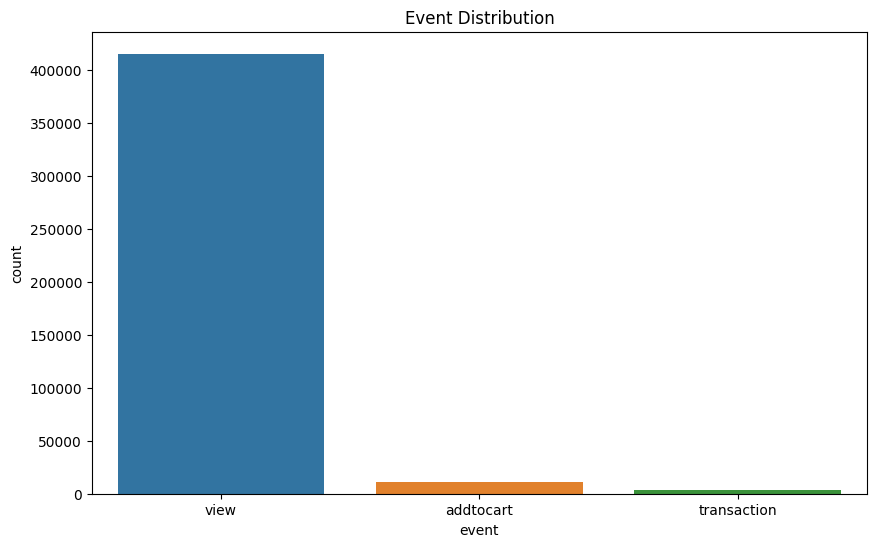

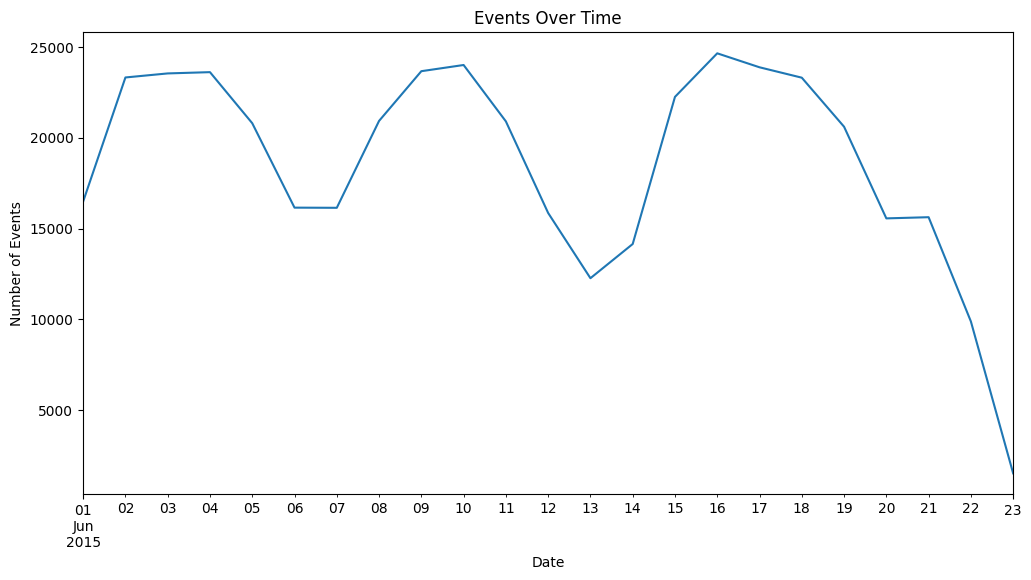

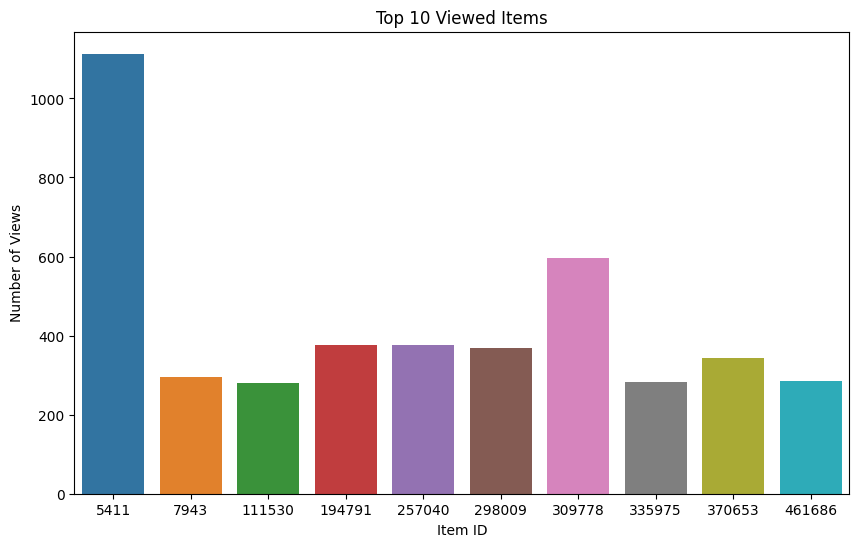

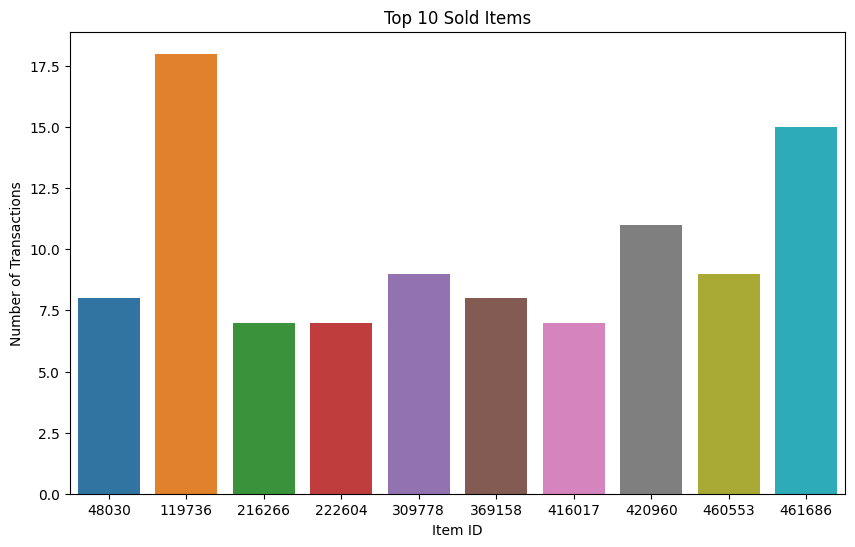

In [14]:
# Calling EDA function

EDAs()

In [15]:
#merging category tree data with items data
df_merged_events = df_events.merge(df_combined_item_properties, on=['itemid', 'timestamp'], how='left').merge(df_category_tree, left_on='property', right_on='categoryid', how='left')
df_merged_events.sample()

,timestamp,visitorid,event,itemid,transactionid,datetime,property,value,categoryid,parentid
219986,1434255435432,1011832,view,129490,NaN,2015-06-14 04:17:15.432,NaN,NaN,NaN,NaN


In [16]:
# top-category views
def topCategoryViewsEDA():
  top_categories_views = df_merged_events[df_merged_events['event'] == 'view']['parentid'].value_counts().head(10)
  if not top_categories_views.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_views.index, y=top_categories_views.values)
    plt.title('Top 10 Categories by Views')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Views')
    plt.show()
  else:
      print("No data available for Top Categories by Views")

# top-category-transactions

def topCategoryTransactionsEDA():
  top_categories_transactions = df_merged_events[df_merged_events['event'] == 'transaction']['parentid'].value_counts().head(10)

  if not top_categories_transactions.empty:
      plt.figure(figsize=(10, 6))
      sns.barplot(x=top_categories_transactions.index, y=top_categories_transactions.values)
      plt.title('Top 10 Categories by Transactions')
      plt.xlabel('Category ID')
      plt.ylabel('Number of Transactions')
      plt.show()
  else:
    print("No data available for Top Categories by Transactions")

#priting EDAs of top category views and top category Transactions
topCategoryViewsEDA()
topCategoryTransactionsEDA()

No data available for Top Categories by Views
No data available for Top Categories by Transactions


In [17]:
# correlation plot

def correlationPlot():
  df_user_item_merged = df_merged_events.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
})

  correlation_matrix = df_user_item_merged.corr()
  plt.figure(figsize=(10, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Correlation between User Attributes and Item Attributes')
  plt.show()

In [18]:
# Add to Cart to Transactions conversion rate

def addToCartToTransactionRate():
  df_add_to_cart = df_events[df_events['event'] == 'addtocart']
  df_transactions = df_events[df_events['event'] == 'transaction']
  conversion_rate = len(df_transactions) / len(df_add_to_cart)
  print(f"Add-to-cart to transaction conversion rate: {conversion_rate:.2%}")


In [19]:
# Active Users

def topActiveUsers():
  top_active_users = df_events['visitorid'].value_counts().head(10)
  plt.figure(figsize=(10, 6))
  sns.barplot(x=top_active_users.index, y=top_active_users.values)
  plt.title('Top 10 Most Active Users')
  plt.xlabel('User ID')
  plt.ylabel('Number of Events')
  plt.show()

In [20]:
# Distribution of events per user

def perUserEventsDistribution():
  events_per_user = df_events['visitorid'].value_counts()
  plt.figure(figsize=(10, 6))
  sns.histplot(events_per_user, kde=False, bins=50)
  plt.title('Distribution of Events per User')
  plt.xlabel('Number of Events')
  plt.ylabel('Number of Users')
  plt.show()

In [21]:
# Distribution of viewed items per user
def viewedItemsPerUser():
  viewed_items_per_user = df_events[df_events['event'] == 'view'].groupby('visitorid')['itemid'].nunique()
  plt.figure(figsize=(10, 6))
  sns.histplot(viewed_items_per_user, kde=False, bins=50)
  plt.title('Distribution of Viewed Items per User')
  plt.xlabel('Number of Unique Items Viewed')
  plt.ylabel('Number of Users')
  plt.show()

In [22]:
# Distribution of purchased items per user

def purchasedItemsPerUser():
  purchased_items_per_user = df_events[df_events['event'] == 'transaction'].groupby('visitorid')['itemid'].nunique()
  plt.figure(figsize=(10, 6))
  sns.histplot(purchased_items_per_user, kde=False, bins=50)
  plt.title('Distribution of Purchased Items per User')
  plt.xlabel('Number of Unique Items Purchased')
  plt.ylabel('Number of Users')
  plt.show()

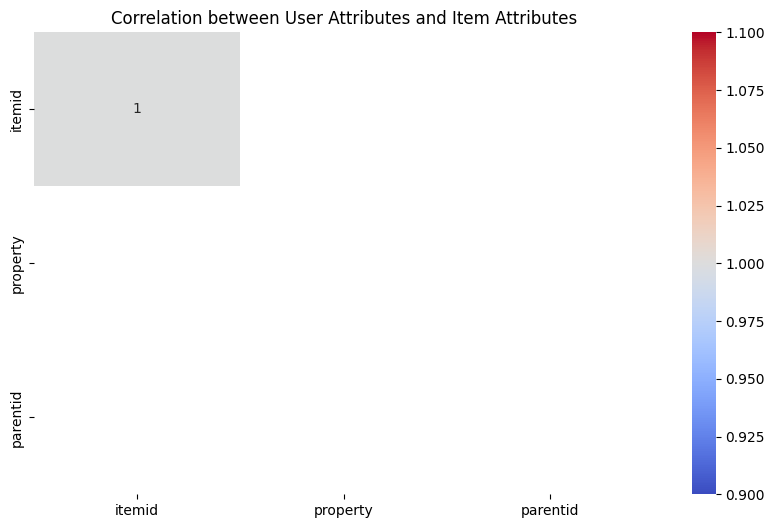

Add-to-cart to transaction conversion rate: 32.80%


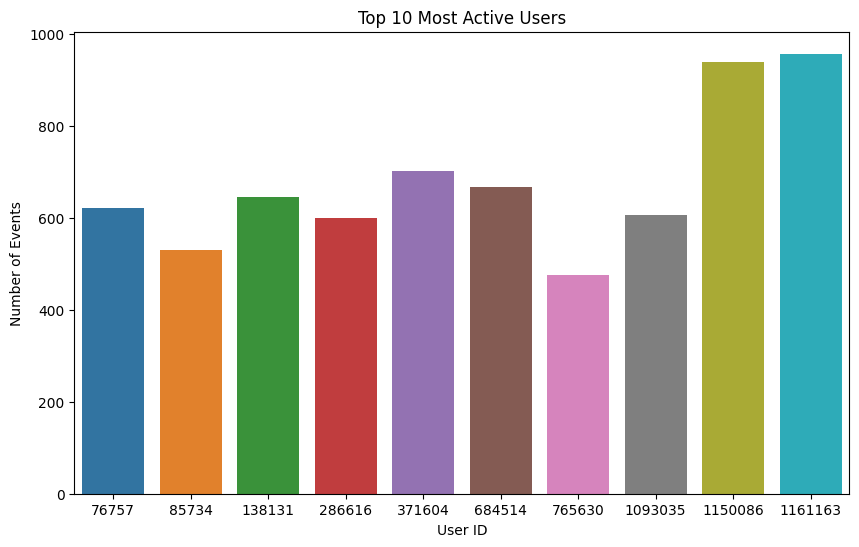

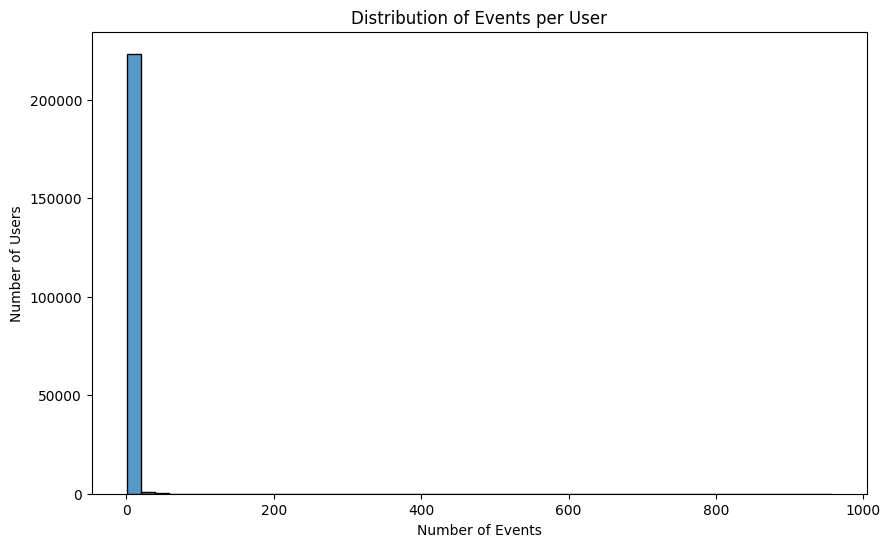

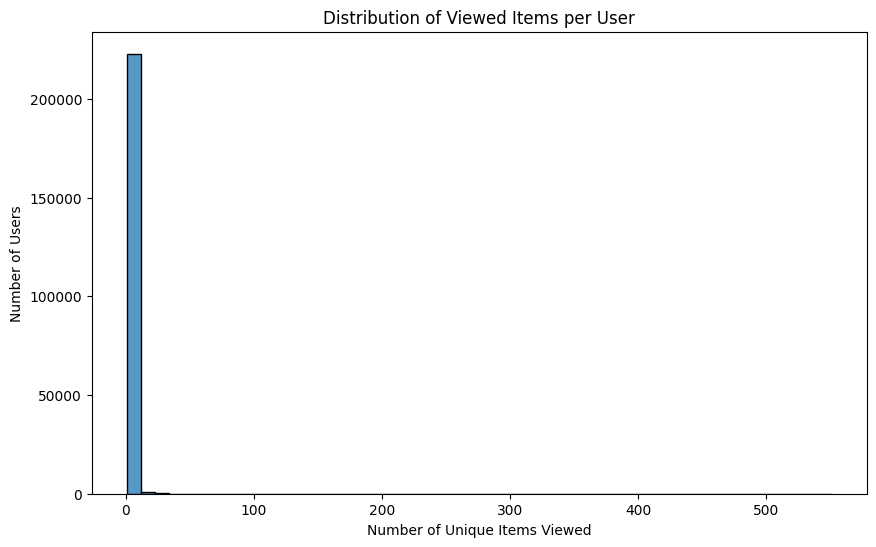

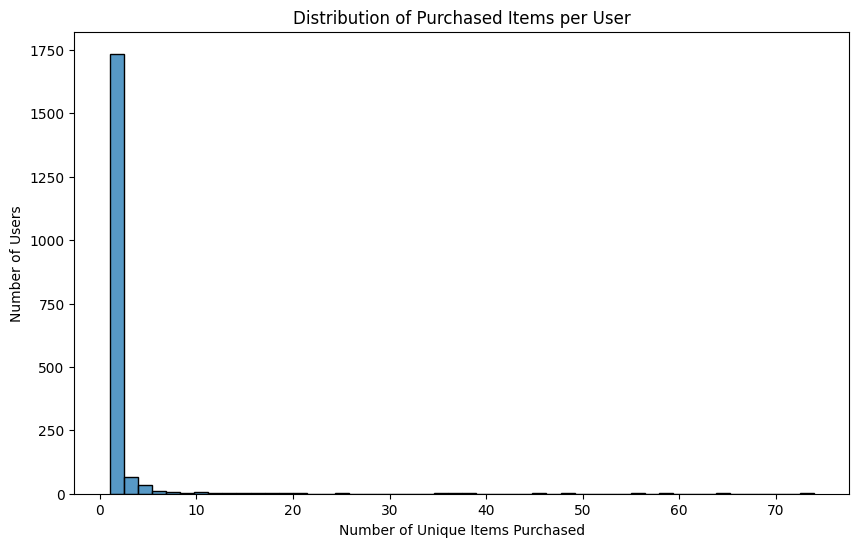

In [23]:
# plots
correlationPlot()
addToCartToTransactionRate()
topActiveUsers()
perUserEventsDistribution()
viewedItemsPerUser()
purchasedItemsPerUser()

In [24]:
# Load the data (assuming you already have the merged_events DataFrame from the EDA)
df = df_merged_events.copy()

In [25]:
# User based feature
def userBasedFeatures():
  user_behaviour = df.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
    'timestamp': ['min', 'max', 'mean']
  }).reset_index()

  user_behaviour.columns = ['visitorid', 'item_count', 'property_count', 'category_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
  user_behaviour['time_on_platform'] = user_behaviour['last_interaction'] - user_behaviour['first_interaction']
  user_behaviour['time_between_actions'] = user_behaviour['time_on_platform'] / (user_behaviour['item_count'] - 1)

  return user_behaviour

In [26]:
# Items based features
def itemBasedFeatures():
  item_popularity = df.groupby('itemid').agg({
    'visitorid': 'count',
    'event': ['nunique', lambda x: sum(x == 'view'), lambda x: sum(x == 'addtocart'), lambda x: sum(x == 'transaction')]
  }).reset_index()

  item_popularity.columns = ['itemid', 'user_count', 'event_count', 'view_count', 'addtocart_count', 'transaction_count']
  item_popularity['conversion_rate'] = item_popularity['transaction_count'] / item_popularity['addtocart_count']

  return item_popularity


In [27]:
# user-item interaction

def userItemInteractionFeature():
  user_item_interactions = df.groupby(['visitorid', 'itemid']).agg({
    'event': 'count',
    'timestamp': ['min', 'max']
  }).reset_index()

  user_item_interactions.columns = ['visitorid', 'itemid', 'interaction_count', 'first_interaction', 'last_interaction']
  user_item_interactions['time_between_interactions'] = user_item_interactions['last_interaction'] - user_item_interactions['first_interaction']

  return user_item_interactions

In [28]:
# calling feature functions that we implemented above

user_behaviour=userBasedFeatures()
item_popularity=itemBasedFeatures()
user_item_interactions=userItemInteractionFeature()

In [29]:
#Merging features into  a single dataframe

def mergeFeatures():
  user_features = user_behaviour.drop(['first_interaction', 'last_interaction'], axis=1)
  item_features = item_popularity.drop(['view_count', 'addtocart_count', 'transaction_count'], axis=1)
  interaction_features = user_item_interactions.drop(['first_interaction', 'last_interaction'], axis=1)

  df_features = interaction_features.merge(user_features, on='visitorid').merge(item_features, on='itemid')
  return df_features

In [30]:
# calling merge feature function
df_features=mergeFeatures()


In [31]:
df_features

,visitorid,itemid,interaction_count,time_between_interactions,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion_rate
0,13,278689,1,0,2,0,0,1.434603e+12,53033,5.303300e+04,2,1,NaN
1,1076648,278689,1,0,1,0,0,1.434424e+12,0,NaN,2,1,NaN
2,13,320589,1,0,2,0,0,1.434603e+12,53033,5.303300e+04,1,1,NaN
3,17,138434,1,0,1,0,0,1.433212e+12,0,NaN,23,1,NaN
4,125596,138434,1,0,7,0,0,1.433231e+12,1631611,2.719352e+05,23,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
333407,1407342,157497,1,0,1,0,0,1.434514e+12,0,NaN,1,1,NaN
333408,1407374,404894,3,538090,7,0,0,1.433468e+12,260679100,4.344652e+07,3,1,NaN
333409,1407374,459841,1,0,7,0,0,1.433468e+12,260679100,4.344652e+07,1,1,NaN
333410,1407408,365945,1,0,1,0,0,1.434265e+12,0,NaN,1,1,NaN


In [32]:
#managing missing/undefined/infinity values in features df

def manageOutliersAndMissing(df_features):
  # Replace infinity values with NaN
  df_features = df_features.replace([np.inf, -np.inf], np.nan)

  # Fill NaN values with the median
  df_features = df_features.fillna(df_features.median())

  return df_features



In [33]:
#Data preprocessing,spiliting and normalization

df_updated_features=manageOutliersAndMissing(df_features)
train_data, test_data = train_test_split(df_updated_features, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

In [34]:
# function to perform collaborative filtering using SVD
def performCollaborativeFiltering():
  reader = Reader(rating_scale=(0, 1))
  train_dataset = Dataset.load_from_df(train_data[['visitorid', 'itemid', 'interaction_count']], reader)
  trainset = train_dataset.build_full_trainset()

  param_grid = {'n_factors': [10, 50, 100], 'n_epochs': [20, 50], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
  gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
  gs.fit(train_dataset)

  # Best hyperparameters
  best_params = gs.best_params['rmse']
  print(f"Best hyperparameters for RMSE: {best_params}")

  # Train the model with the best hyperparameters
  algo = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
  algo.fit(trainset)

  # Model evaluation
  testset = list(zip(test_data['visitorid'].values, test_data['itemid'].values, test_data['interaction_count'].values))
  predictions = algo.test(testset)
  # Calculate evaluation metrics
  mae = mean_absolute_error(test_data['interaction_count'], [pred.est for pred in predictions])

  accu_score=1/(1+mae)
  normalized_score=(accu_score - mae) / (accu_score + mae) *2

  print(f"Mean Absolute Error: {mae}")
  print(f"normalized prediction score: {normalized_score}")
  print(f"Accuracy score: {accu_score}")

  return predictions


In [35]:
# run the SVD algo
predictions_from_svd=performCollaborativeFiltering()

Best hyperparameters for RMSE: {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.1}
Mean Absolute Error: 0.28781765292195516
normalized prediction score: 0.9183092553348476
Accuracy score: 0.7765074486524393


In [36]:
# function to get list of recommended items for each user

def getRecommendationlist(predictions,n=10):
  top_n = {}
  for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

  for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

  return top_n

In [37]:
# function to get recommended item list for a user

def getListOfUser(user_id,top_n=getRecommendationlist(predictions_from_svd,n=10)):
  try:
    recommended_items = [item[0] for item in top_n[user_id]]
    print(f"Top recommended items for user {user_id}: {recommended_items}")
    return recommended_items
  except KeyError:
    print(f"User {user_id} not found in the recommendations.")


In [38]:
# get list for a random user_iist

user_recommendation_list=getRecommendationlist(predictions_from_svd,n=10)
random_user_id=random.choice(list(user_recommendation_list.keys()))

getListOfUser(random_user_id,user_recommendation_list)

Top recommended items for user 1031485: [318481]


[318481]

In [39]:
# function to get visualization graph for prediction model

def visualizePredictions(predictions):
  sample_users = np.random.choice(test_data['visitorid'].unique(), size=10, replace=False)
  sample_preds = [pred for pred in predictions if pred.uid in sample_users]

  true_counts = [pred.r_ui for pred in sample_preds]
  predicted_counts = [pred.est for pred in sample_preds]

  plt.figure(figsize=(12, 6))
  plt.plot(true_counts, label="True Interaction Counts")
  plt.plot(predicted_counts, label="Predicted Interaction Counts")
  plt.xlabel("Sample Users")
  plt.ylabel("Interaction Counts")
  plt.legend()
  plt.title("True vs. Predicted Interaction Counts for Sample Users")
  plt.show()

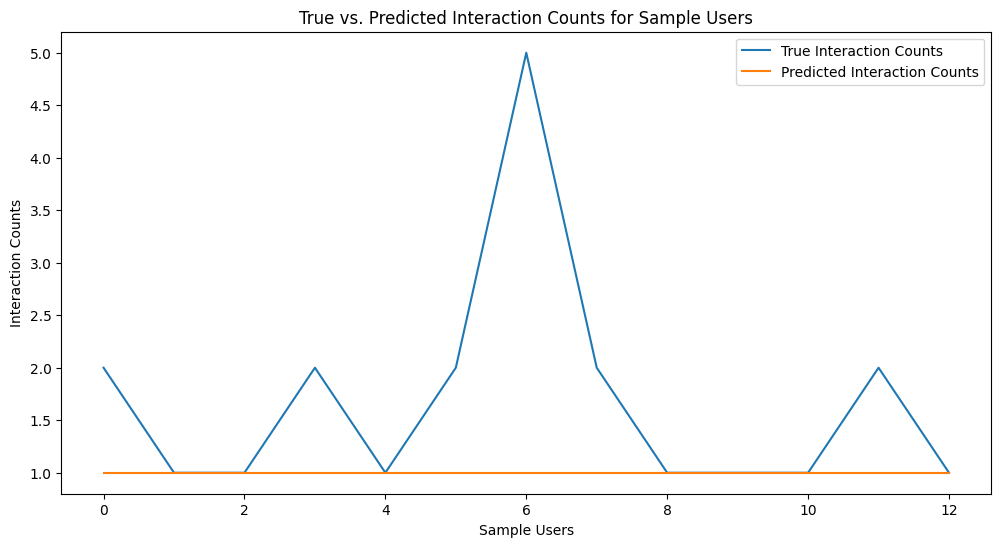

In [40]:
# plot the prediction graph
visualizePredictions(predictions_from_svd)
